# Forced, Parameterized and Coupled Modeling on Lorenz96 examples

> **tldr:** This notebook demonstrates various ways to model systems with multiple interacting components using the Lorenz96 model as an example. You will learn how to: (1) Build single-component models that account for missing physics using parameterizations, such as adding a stochastic term or explicitly "forcing" the model with user-provided data. (2) Create a modular, two-way coupled system by running two independent models and enabling them to exchange information at each timestep.

In this demo we will use Lorenz96 system to demonstrate how to set up a variety of models using NeuralGCM codebase. We will cover:
1. Two scale Lorenz96 model that by construction includes multiple components
2. Single scale Lorenz96 model with parameterizations (a.k.a. closure)
    1. Stochastic closure for slow mode Lorenz96 model
    2. Slow mode Lorenz96 model explicitly forced with fast mode data
    3. Fast mode Lorenz96 model explicitly forced with slow mode data
3. Two scale Lorenz96 model constructed by coupling slow and fast `Model` instances

In [2]:
# Imports for the demo.

import dataclasses
import math

from typing import Any, Sequence

import coordax as cx
from flax import nnx
import jax.numpy as jnp
import jax_datetime as jdt
import numpy as np
import matplotlib.pyplot as plt
import xarray

from neuralgcm.experimental.core import api
from neuralgcm.experimental.core import coordinates
from neuralgcm.experimental.core import dynamic_io
from neuralgcm.experimental.core import feature_transforms
from neuralgcm.experimental.core import transforms
from neuralgcm.experimental.core import module_utils
from neuralgcm.experimental.core import nnx_compat
from neuralgcm.experimental.core import random_processes
from neuralgcm.experimental.core import observation_operators
from neuralgcm.experimental.core import typing
from neuralgcm.experimental.core import xarray_utils
from neuralgcm.experimental.toy_model_examples import lorenz96

# small formatting improvements
np.set_printoptions(threshold=100)
import logging
import warnings
warnings.simplefilter('ignore')
logging.getLogger('jax._src.lib.xla_bridge').addFilter(lambda _: False)

In [64]:
# Helper function for generating model rollous.

@nnx.jit(static_argnums=(1, 3))
def unroll_model(
    model,
    outer_steps: int,
    query,
    inner_steps: int = 1,
) -> dict[str, dict[str, cx.Field]]:
  """Runs simulation calling `model.observe(query)` every `innfer_steps`."""
  def _inner(model):
    model.advance()

  in_axes = nnx.StateAxes({typing.SimulationVariable: nnx.Carry, ...: None})
  inner_step = nnx.scan(_inner, length=inner_steps, in_axes=in_axes, out_axes=0)

  def _step(model):
    observation = model.observe(query)
    inner_step(model)
    return observation

  unroll = nnx.scan(_step, length=outer_steps, in_axes=in_axes, out_axes=0)
  observations = unroll(model)
  # time = cx.LabeledAxis('timedelta', np.arange(outer_steps) * inner_steps)
  time = cx.LabeledAxis('timedelta', np.arange(outer_steps))
  observations = cx.tag(observations, time)
  return observations

## Two scale Lorenz96

First we will note that `api.Model` instance can include multiple components explicitly. `Lorenz96WithTwoScales` is one such examples, that keeps track of both slow `X` and fast `Y` variables and explicitly implements coupling between the two.

This approach provides most control over how variables are coupled, but might lead to less modular and more complex model code when modeling much more complex systems like Earth System Models.

Here we will use `Lorenz96WithTwoScales` predictions to generate a steady state rollout that will be interpreted as "ground truth" in the following sections.

In [105]:
#@title Building model and running Lorenz96 with two scales

k, j = cx.LabeledAxis('k', np.arange(36)), cx.LabeledAxis('j', np.arange(8))
l96_model_two_scales = lorenz96.Lorenz96WithTwoScales(k, j)

# Sample two scale model inputs.
kj = cx.compose_coordinates(k, j)
t0 = jdt.Datetime.from_isoformat('2000-01-01')
dt = coordinates.TimeDelta(np.zeros(1) * np.timedelta64(1, 'h'))
rng = np.random.RandomState(0)

x_init = abs(10 * np.sin(np.linspace(0, 13 * 2 * np.pi, k.sizes['k'])))
inputs = {
    'slow': {
        'x': cx.field(x_init[None, :], dt, k),
        'time': cx.field(t0[None], dt),
    },
    'fast': {
        'y': cx.field(rng.uniform(-0.5, 0.5, dt.shape + kj.shape), dt, kj),
        'time': cx.field(t0[None], dt),
    },
}

# Running burn-in phase to get to a steady state.
l96_model_two_scales.assimilate(inputs)
_ = unroll_model(l96_model_two_scales, 500, {}, inner_steps=25)

# Let's save current state for later initialization
x1, y1 = l96_model_two_scales.x.value.data, l96_model_two_scales.y.value.data
t1 = l96_model_two_scales.time.value.data
slow_mode_inputs = {
    'slow': {
        'x': cx.field(x1[None, :], dt, k), 'time': cx.field(t1[None], dt)
    },
}
fast_mode_inputs = {
    'fast': {
        'y': cx.field(y1[None, :], dt, kj), 'time': cx.field(t1[None], dt)
    },
}

# Producing a long rollout outputting both slow and fast modes + time.
n_steps = 2000
queries = {
    'slow': {'x': k, 'time': cx.Scalar()},
    'fast': {'y': kj, 'time': cx.Scalar()},
}
all_targets = unroll_model(l96_model_two_scales, n_steps, queries)

# Prep datasets for plotting the ground truth.
targets_slow_ds = xarray_utils.fields_to_xarray(all_targets['slow'])
targets_fast_ds = xarray_utils.fields_to_xarray(all_targets['fast'])
targets_fast_ds = targets_fast_ds.stack(k_prime=('k', 'j'))
targets_fast_ds.coords['k_prime'] = np.linspace(0, k.sizes['k'], math.prod(kj.shape))

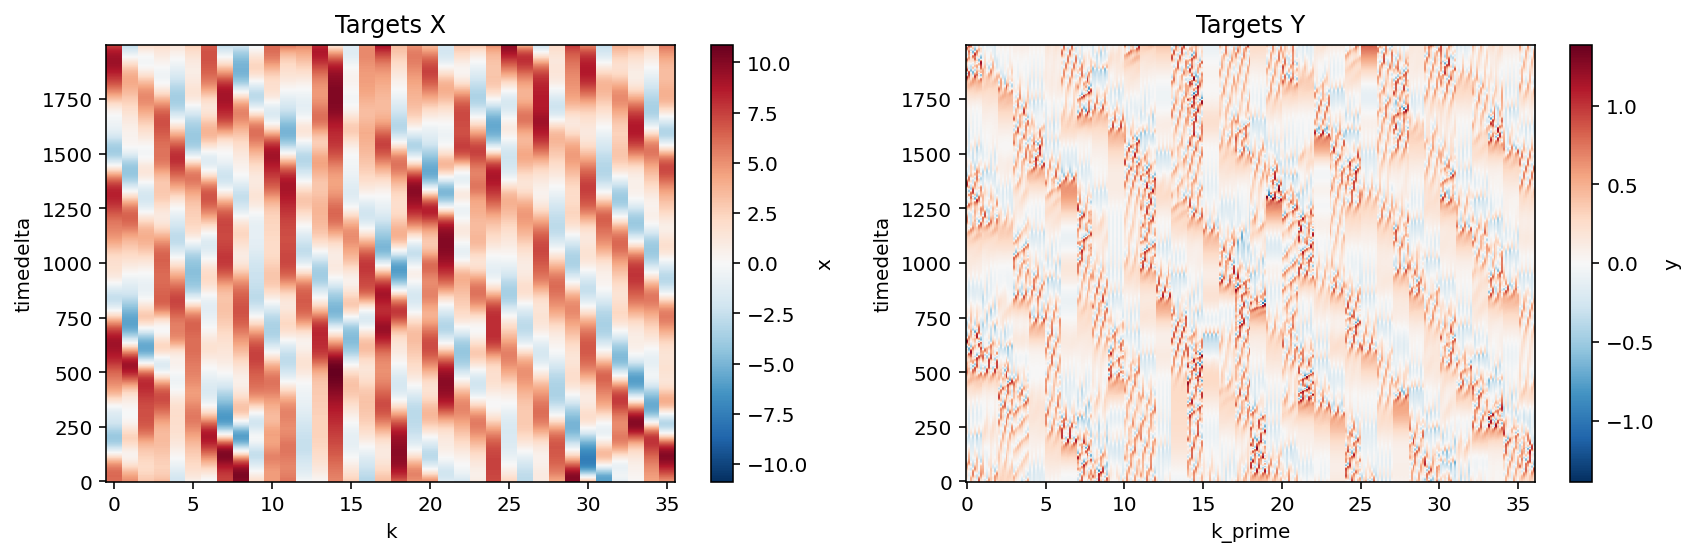

In [138]:
# Visualizing outputs of the original model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

targets_slow_ds.x.plot(x='k', y='timedelta', ax=ax1)
ax1.set_title('Targets X')
targets_fast_ds.y.plot.imshow(x='k_prime', y='timedelta', ax=ax2)
ax2.set_title('Targets Y')
plt.tight_layout()

The simulation above includes `X` and `Y` variables coupled to one another through each iteration of the RungeKutta4 time integrator.

In the following sections we will aim to produce outputs that mimic the predictions of some or all of the component while solving equations for `X` and `Y` independently.

## Single scale Lorenz96 with parameterizations

**Examples:**
* Using `RandomProcess` to build a stochastic parameterization
* Using `DynamicInputs` to force model with user provided inputs

Assuming that full `Lorenz96WithTwoScales` simulation to be the ground truth, we can go through the exercise of building models that only include one of the components (`X` or `Y`) and try to capture their evolution.

Let us start with simply running a slow mode `Lorenz96` model to show how interactions with fast variable `Y` affects evolution of the slow variables `X`.



In [107]:
default_x_l96 = lorenz96.Lorenz96(k)
default_x_l96.assimilate(slow_mode_inputs)
default_x_predictions = unroll_model(default_x_l96, n_steps, {'slow': {'x': k}})
default_x_slow_ds = xarray_utils.fields_to_xarray(default_x_predictions['slow'])

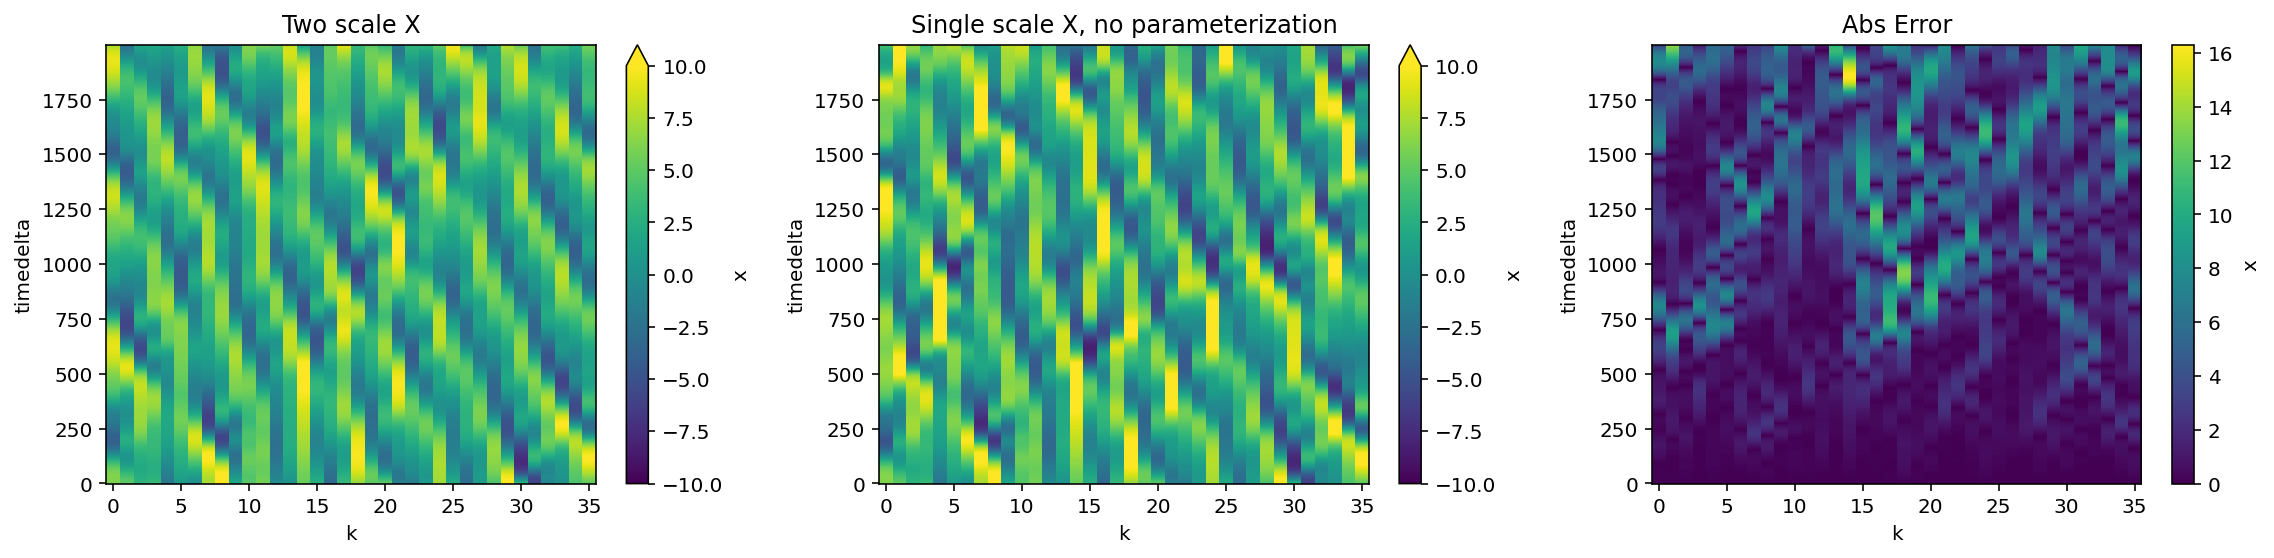

In [109]:
# Comparing predictions of `X` with and without interactions with `Y`
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
vmin, vmax = -10.0, 10.0
targets_slow_ds.x.plot(x='k', y='timedelta', ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('Two scale X')
default_x_slow_ds.x.plot.imshow(x='k', y='timedelta', ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('Single scale X, no parameterization')

abs((default_x_slow_ds.x - targets_slow_ds.x)).plot.imshow(x='k', y='timedelta', ax=ax3)
ax3.set_title('Abs Error')
plt.tight_layout()

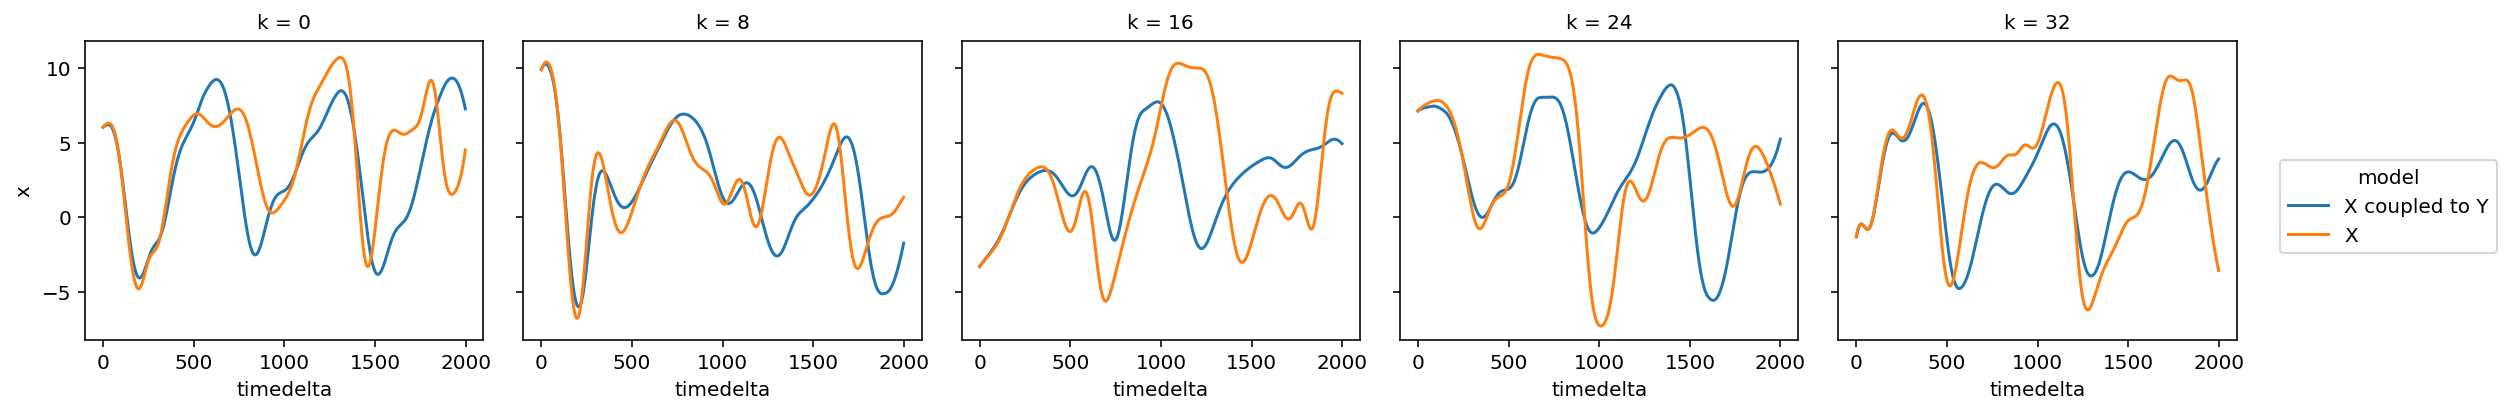

In [110]:
combined_ds = xarray.concat([targets_slow_ds, default_x_slow_ds], 'model')
combined_ds.coords['model'] = ['X coupled to Y', 'X']
combined_ds.thin(k=8).x.plot(x='timedelta', col='k', hue='model')

From the two plots we notice that outputs vary substantially in the presence of `Y` coupling. Let us now build variations of better models.

### Adding stochastic parameterization

First we will build a model that tries to account for the effect of `Y` variables via a stochastic parameterization term. Under the hood the parameterization will simply add a correction to the `X` variables at each step of the form:

```
-(b0 + b1 * X) * dt + noise_amplitude * N(0, 1) * sqrt(dt)
```

In [119]:
random_process = random_processes.NormalUncorrelated(
    mean=0.0, std=1.0, coords=k, rngs=nnx.Rngs(0)
)
stochastic_parameterization = lorenz96.StochasticLinearParameterization(
    random_process=random_process
)
stochastic_x_l96 = lorenz96.Lorenz96(k, [stochastic_parameterization])
stochastic_x_l96.assimilate(slow_mode_inputs)
stochastic_x_predictions = unroll_model(
    stochastic_x_l96, n_steps, {'slow': {'x': k}}
)
stochastic_x_slow_ds = xarray_utils.fields_to_xarray(stochastic_x_predictions['slow'])

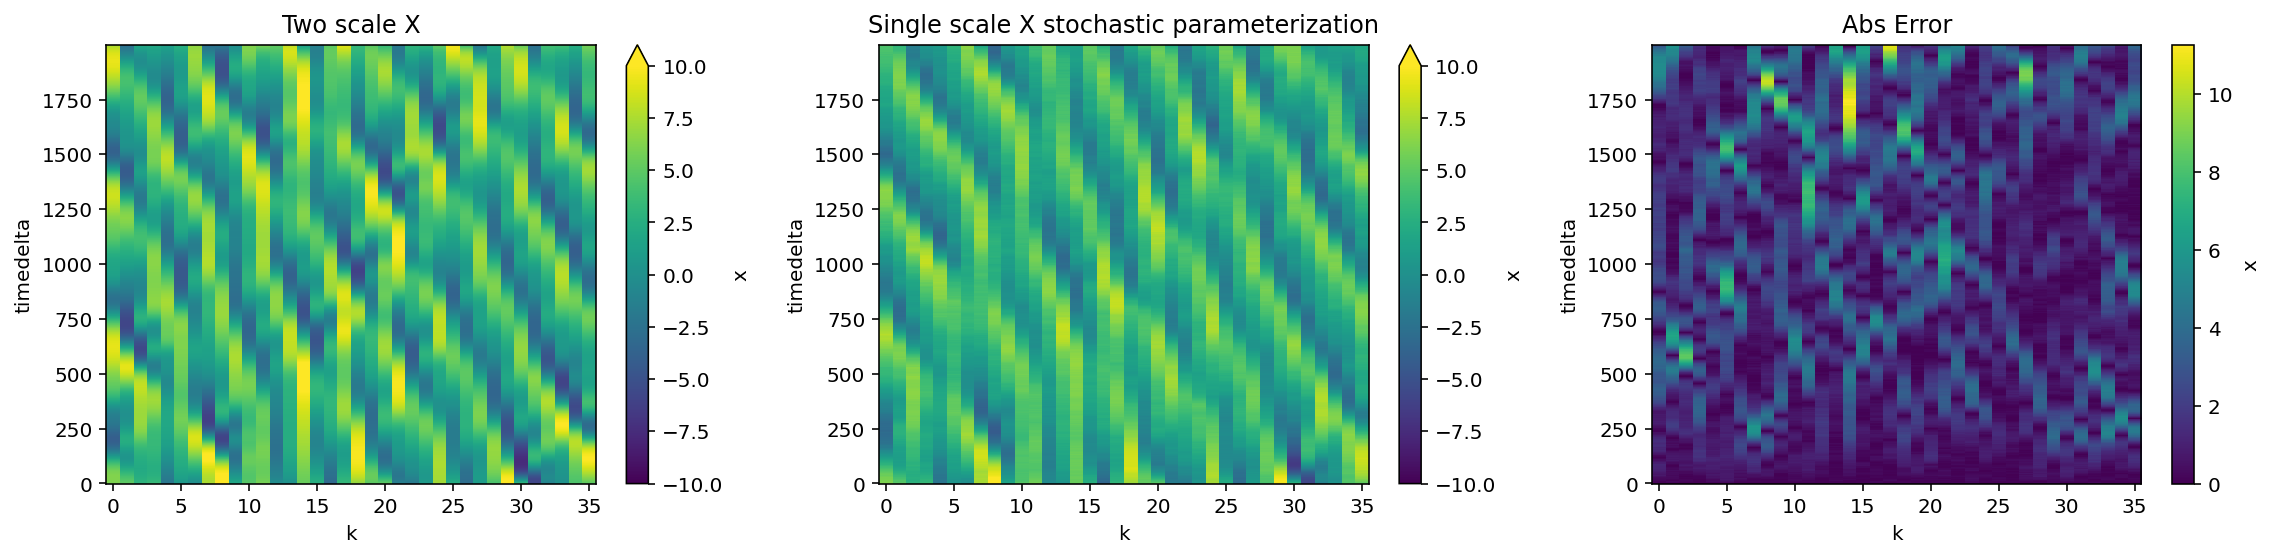

In [120]:
# Comparing predictions of `X` with and without interactions with `Y`
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
vmin, vmax = -10.0, 10.0

targets_slow_ds.x.plot(x='k', y='timedelta', ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('Two scale X')
stochastic_x_slow_ds.x.plot.imshow(x='k', y='timedelta', ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('Single scale X stochastic parameterization')

abs((stochastic_x_slow_ds.x - targets_slow_ds.x)).plot.imshow(x='k', y='timedelta', ax=ax3)
ax3.set_title('Abs Error')
plt.tight_layout()

While adding noise did not noticeably reduce the absolute error, this parameterization does adjust the behavior of the model to be statistically more similar to that of the original when looking at evolution of `X[k]`:

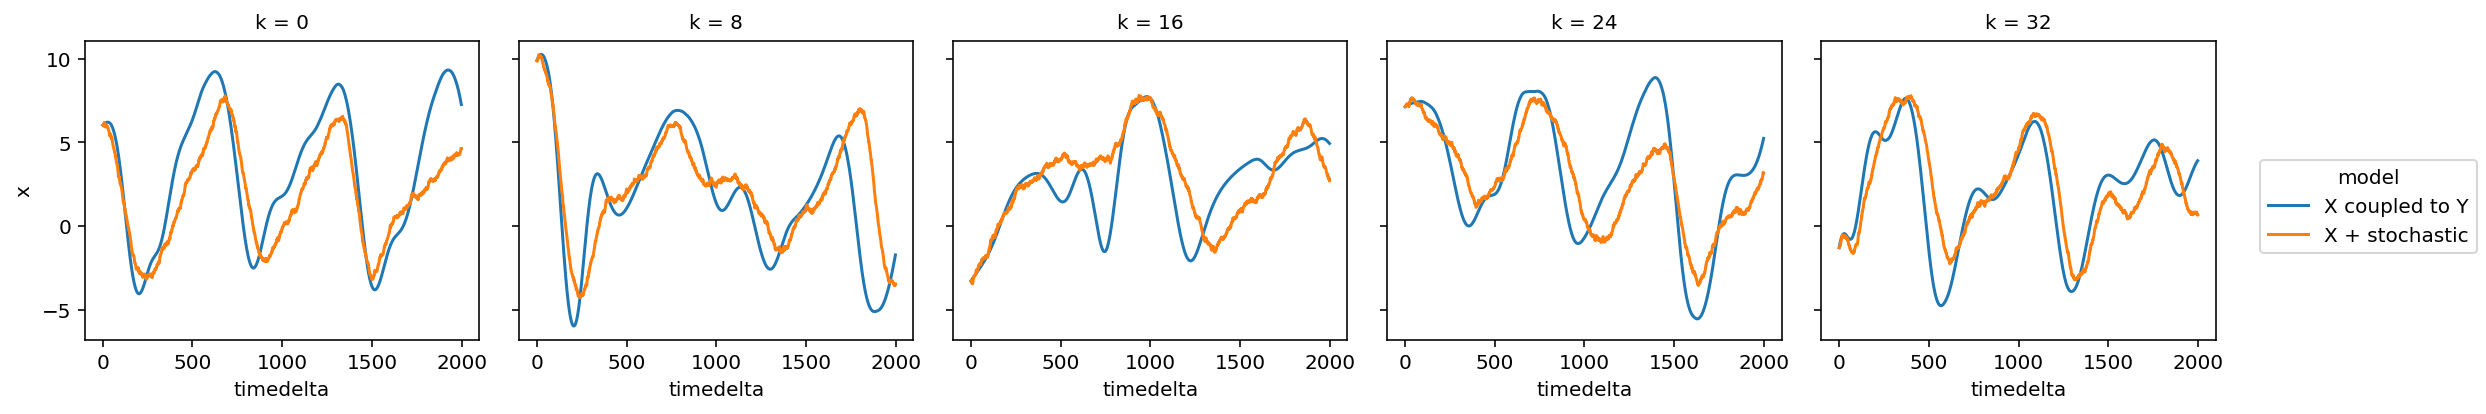

In [121]:
combined_ds = xarray.concat([targets_slow_ds, stochastic_x_slow_ds], 'model')
combined_ds.coords['model'] = ['X coupled to Y', 'X + stochastic']
combined_ds.thin(k=8).x.plot(x='timedelta', col='k', hue='model')

### Adding parameterization forced by user-provided data

Sometimes it is easier to build model components one at a time. For example, one might want to build an ocean model and force it with prescribed atmospheric dynamics.

To do that on the `Lorenz96` example we will first define a simple, yet highly customizable parameterization module:

In [122]:
# Euler update parameterization module specified by transforms.

@nnx_compat.dataclass
class EulerParameterization(nnx.Module):
  """L96Parameterization mapping prognostics to euler-delta for."""

  transform: transforms.Transform
  delta_key: str

  def __call__(
      self,
      prognostics: dict[str, cx.Field],
      dt: float,
  ) -> cx.Field:
    return dt * self.transform(prognostics)[self.delta_key]

Now we will implement our goal is to implement a transform that given model prognostics `(x, time)` will:
1. Fetch `y` variables for corresponding `time` from user-provided data
2. Compute forcing `-(hc/b) * sum_over_y(y)`


In [123]:
# DynamicInputSlice will manage dynamic inputs for Y variables.
dynamic_y = dynamic_io.DynamicInputSlice({'y': kj}, observation_key='fast')
y_features = feature_transforms.DynamicInputFeatures(['y'], dynamic_y)

h, c, b = 1.0, 10.0, 10.0  # will use expected parameters.
y_to_coupling_fn = lambda y: -(h * c / b) * cx.cmap(jnp.sum)(y.untag('j'))
y_to_coupling = transforms.ApplyFnToKeys(y_to_coupling_fn, ['y'])
parameterization_transform = transforms.Sequential([y_features, y_to_coupling])
forced_parameterization = EulerParameterization(parameterization_transform, 'y')

forced_x_l96 = lorenz96.Lorenz96(k, [forced_parameterization])
forced_x_l96.assimilate(slow_mode_inputs)
forced_x_l96.update_dynamic_inputs({'fast': all_targets['fast']})
forced_x_predictions = unroll_model(
    forced_x_l96, n_steps, {'slow': {'x': k}}
)
forced_x_slow_ds = xarray_utils.fields_to_xarray(forced_x_predictions['slow'])

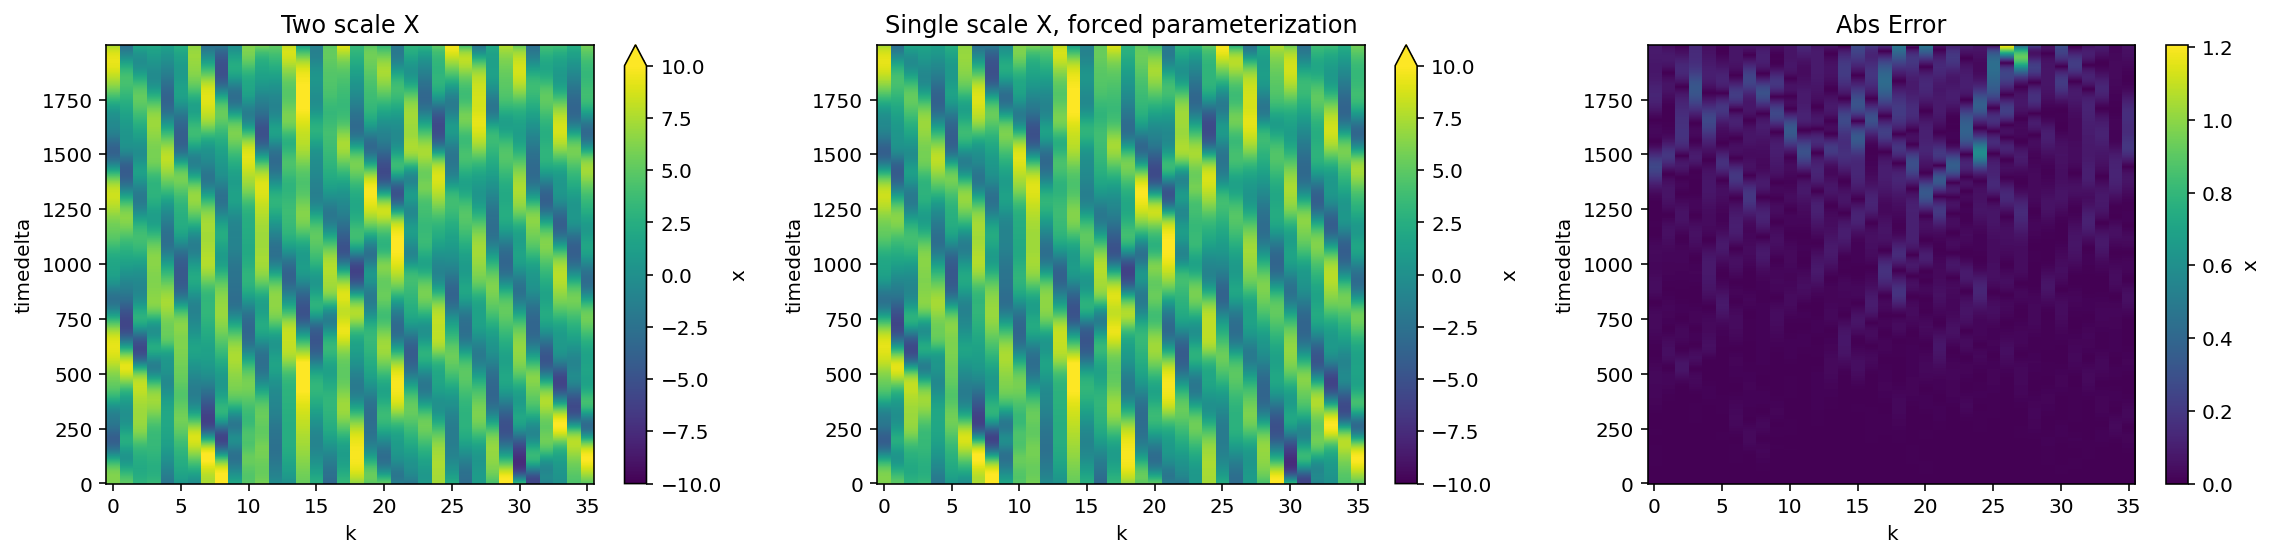

In [124]:
# Comparing predictions of `X` with and without interactions with `Y`
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
vmin, vmax = -10.0, 10.0

targets_slow_ds.x.plot(x='k', y='timedelta', ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('Two scale X')
forced_x_slow_ds.x.plot.imshow(x='k', y='timedelta', ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('Single scale X, forced parameterization')

abs((forced_x_slow_ds.x - targets_slow_ds.x)).plot.imshow(x='k', y='timedelta', ax=ax3)
ax3.set_title('Abs Error')
plt.tight_layout()

This results in much improved forecasts, since it was explicitly forced with `Y` variables from the two scale simulation.

The results are not numerically the same because here we use Euler update for the coupling and only see `Y` values separated by a full step, wheras the ground truth simulation updates `X` and `Y` simultaneously.

If we were to output all intermediate data and define a paramterization that would contribute terms to the underlying equation for `X` we could achieve an exact match.

### Forced parameterization for Y variables

We can use similar approach for forcing `Y` variables with prescribed `X` fields. This mimics forcing an atmosphere with an ocean state. The setup is almost identical to the one above.

In [125]:
# DynamicInputSlice will manage dynamic inputs for x variables.
dynamic_x = dynamic_io.DynamicInputSlice({'x': k}, observation_key='slow')
x_features = feature_transforms.DynamicInputFeatures(['x'], dynamic_x)

h, c, b = 1.0, 10.0, 10.0  # will use expected parameters.
x_to_coupling_fn = lambda x: (h * c / b) * x
x_to_coupling = transforms.ApplyFnToKeys(x_to_coupling_fn, ['x'])
parameterization_transform = transforms.Sequential([x_features, x_to_coupling])
forced_parameterization = EulerParameterization(parameterization_transform, 'x')

forced_y_l96 = lorenz96.Lorenz96FastMode(k, j, [forced_parameterization])
forced_y_l96.assimilate(fast_mode_inputs)
forced_y_l96.update_dynamic_inputs({'slow': all_targets['slow']})
forced_y_predictions = unroll_model(
    forced_y_l96, n_steps, {'fast': {'y': kj}}
)
forced_y_fast_ds = xarray_utils.fields_to_xarray(forced_y_predictions['fast'])
forced_y_fast_ds = forced_y_fast_ds.stack(k_prime=('k', 'j'))
forced_y_fast_ds.coords['k_prime'] = np.linspace(0, k.sizes['k'], math.prod(kj.shape))

# Also include model without forcing for comparison.
default_y_l96 = lorenz96.Lorenz96FastMode(k, j)

default_y_l96.assimilate(fast_mode_inputs)
default_y_predictions = unroll_model(
    default_y_l96, n_steps, {'fast': {'y': kj}}
)
default_y_fast_ds = xarray_utils.fields_to_xarray(default_y_predictions['fast'])
default_y_fast_ds = default_y_fast_ds.stack(k_prime=('k', 'j'))
default_y_fast_ds.coords['k_prime'] = np.linspace(0, k.sizes['k'], math.prod(kj.shape))

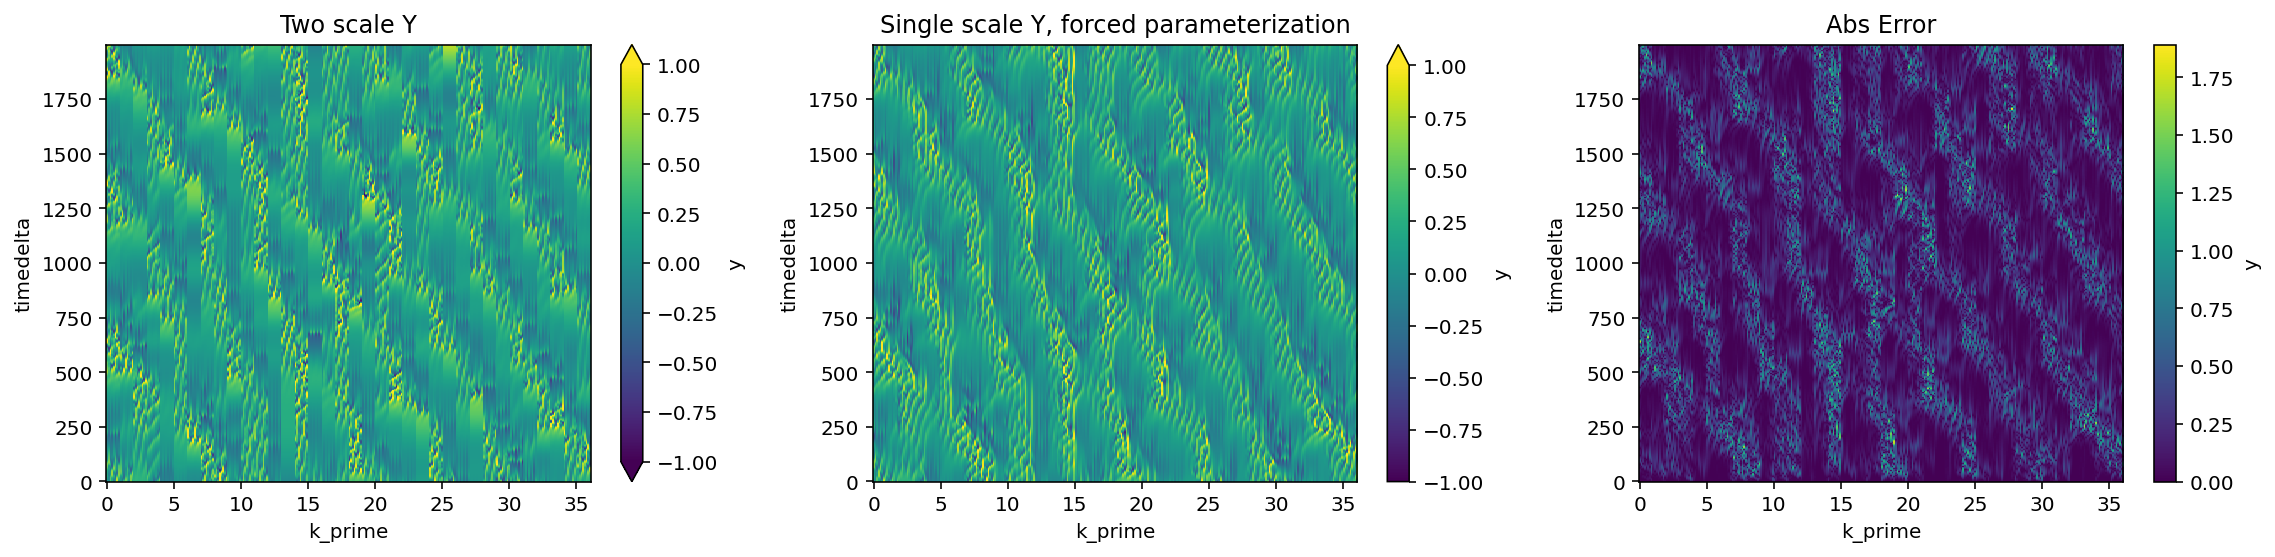

In [126]:
# Comparing predictions of `X` with and without interactions with `Y`
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
vmin, vmax = -1, 1
targets_fast_ds.y.plot(x='k_prime', y='timedelta', ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('Two scale Y')
forced_y_fast_ds.y.plot.imshow(x='k_prime', y='timedelta', ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('Single scale Y, forced parameterization')

err_y = abs((forced_y_fast_ds.y - targets_fast_ds.y))
err_y.plot.imshow(x='k_prime', y='timedelta', ax=ax3)
ax3.set_title('Abs Error')
plt.tight_layout()

The pointwise agreement is lost fairly quickly due to chaos. Note that for the case without parameterization `Y` field quickly decays.

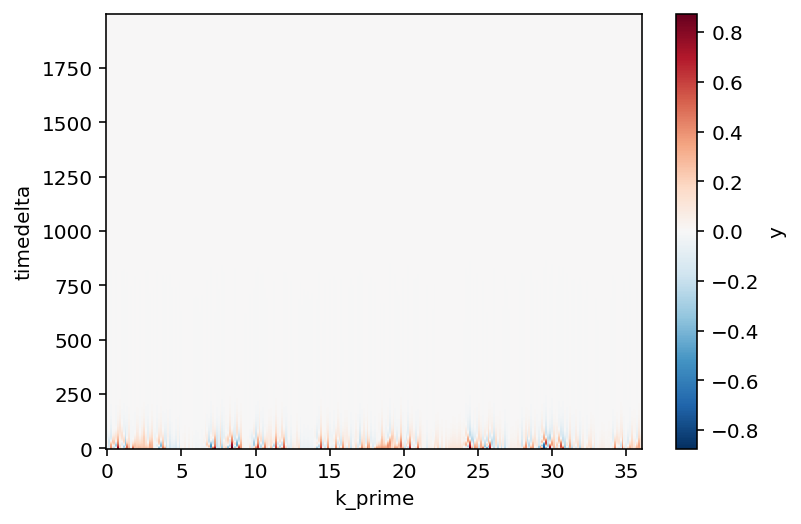

In [127]:
default_y_fast_ds.y.plot.imshow(x='k_prime', y='timedelta')

## Two scale Lorenz96 via explicit coupling

**Examples:**
* Using `DataCoupler` to pass fields between models similar to "dynamic inputs"
* Dispatching queries to unique observation operators

Now we turn our attention to taking two independently developed models (trained with data forcing to represent effects of the other system component) and producing a coupled model.

This usually involves two entities:
* Coupler instances that hold values to be passed between models
* Coupled model that holds coupler and model components

The schema for coupling that we propose below includes following steps:
1. Define couplers that will store and expose `X` and `Y` variable values
2. Use coupler instances to supplement necessary inputs instead of `DynamcInputModule` in each component
3. Define `CoupledLorenz96Model` that orchestrates updates of all components

First we define `DataCoupler`:

In [128]:
@nnx_compat.dataclass
class DataCoupler(nnx.Module):
  """Coupler that stores instant field values copied from model components."""

  field_coords: dict[str, cx.Coordinate]  # coordinates for stored variables.
  var_to_data_keys: dict[str, str]  # field_name to data_key.
  coupling_fields: nnx.Data = dataclasses.field(init=False)

  def __post_init__(self):
    self.coupling_fields = {
        k: typing.Coupling(cx.field(jnp.nan * jnp.zeros(c.shape), c))
        for k, c in self.field_coords.items()
    }

  @module_utils.ensure_unchanged_state_structure
  def update_fields(self, nested_inputs: dict[str, dict[str, cx.Field]]):
    """Updates the fields stored on the coupler from the observations."""
    for k, _ in (self.field_coords).items():
      data_key = self.var_to_data_keys[k]
      if data_key not in nested_inputs:
        raise ValueError(
            f'DataCoupler missing Fields for "{data_key}" needed for "{k}"'
        )
      self.coupling_fields[k].value = nested_inputs[data_key][k]

  def __call__(self, time: jdt.Datetime) -> dict[str, cx.Field]:
    del time  # unused. This implements `dynamic_io.TimedInputProtocol`.
    return {k: v.value for k, v in self.coupling_fields.items()}

In [129]:

# Helper function to be used for queries dispatching.
def get_non_unique_keys(*dict_seq: dict[str, Any]) -> Sequence[str]:
  used_keys = set()
  non_unique_keys = set()
  for in_dict in dict_seq:
    non_unique_keys.update(set(in_dict.keys()).intersection(used_keys))
    used_keys.update(in_dict.keys())
  return tuple(non_unique_keys)


@nnx_compat.dataclass
class CoupledLorenz96(api.Model):
  """Coupled Lorenz96 model with two-way coupling."""

  slow_model: lorenz96.Lorenz96
  fast_model: lorenz96.Lorenz96FastMode
  slow_to_fast_coupler: DataCoupler
  fast_to_slow_coupler: DataCoupler
  operators: dict[str, observation_operators.ObservationOperator] = dataclasses.field(default_factory=dict)
  model_timestep: np.timedelta64 = dataclasses.field(init=False)

  def __post_init__(self):
    if self.slow_model.timestep != self.fast_model.timestep:
      raise ValueError('All models must have the same timestep.')
    self.model_timestep = self.slow_model.timestep
    self.slow_query = {'slow': self.slow_to_fast_coupler.field_coords}
    self.fast_query = {'fast': self.fast_to_slow_coupler.field_coords}
    self.overlapping_operator_keys = get_non_unique_keys(
        self.slow_model.operators, self.fast_model.operators
    )

  @property
  def timestep(self):
    return self.model_timestep

  def assimilate(self, inputs: dict[str, dict[str, cx.Field]]):
    self.slow_model.assimilate(inputs)
    self.fast_model.assimilate(inputs)
    # Updating the couplers after models have been updated.
    slow_values = self.slow_model.observe(self.slow_query)
    fast_values = self.fast_model.observe(self.fast_query)
    self.slow_to_fast_coupler.update_fields(slow_values)
    self.fast_to_slow_coupler.update_fields(fast_values)

  def advance(self):
    self.slow_model.advance()
    self.fast_model.advance()
    # Updating the couplers after models have been updated.
    slow_values = self.slow_model.observe(self.slow_query)
    fast_values = self.fast_model.observe(self.fast_query)
    self.slow_to_fast_coupler.update_fields(slow_values)
    self.fast_to_slow_coupler.update_fields(fast_values)

  def observe(self, queries):
    result = {}
    for k, q in queries.items():
      if k in self.operators:
        result[k] = self.operators[k].observe(self.prognostics, q)
      else:
        if k in self.overlapping_operator_keys:
          raise ValueError(
              f'operator_key "{k}" is present on multiple model components and '
              'cannot be uniquely dispatched. Consider adding resolution to operators.'
          )
        if k in self.slow_model.operators:
          result[k] = self.slow_model.observe({k: q})[k]
        elif k in self.fast_model.operators:
          result[k] = self.fast_model.observe({k: q})[k]
        else:
          raise ValueError(f'No observation operator for key "{k}"')
    return result

  @property
  def required_dynamic_input_specs(
      self,
  ) -> dict[str, dict[str, cx.Coordinate]]:
    """Returns specs for all dynamic io inputs required to run this model."""
    slow_dynamic_specs = self.slow_model.required_dynamic_input_specs
    fast_dynamic_specs = self.fast_model.required_dynamic_input_specs
    return slow_dynamic_specs | fast_dynamic_specs

  @property
  def required_input_specs(self) -> dict[str, dict[str, cx.Coordinate]]:
    slow_inputs = self.slow_model.required_input_specs
    fast_inputs = self.fast_model.required_input_specs
    return slow_inputs | fast_inputs

Now we will construct the model by using `Lorenz96` and `Lorenz96FastMode` components that will use appropriate DataCoupler instances instead of dynamic input modules in the examples before.

This model update is what wires the data from one model component to the other.

In [130]:
# Building coupled model.
coupler_with_x = DataCoupler({'x': k}, {'x': 'slow'})
coupler_with_y = DataCoupler({'y': kj}, {'y': 'fast'})
#
h, c, b = 1.0, 10.0, 10.0  # will use expected parameters.
y_to_coupling_fn = lambda y: -(h * c / b) * cx.cmap(jnp.sum)(y.untag('j'))
y_to_coupling = transforms.ApplyFnToKeys(y_to_coupling_fn, ['y'])
x_parameterization_transform = transforms.Sequential([coupler_with_y, y_to_coupling])
x_coupler_parameterization = EulerParameterization(x_parameterization_transform, 'y')
x_to_coupling_fn = lambda x: (h * c / b) * x  # same as before;
x_to_coupling = transforms.ApplyFnToKeys(x_to_coupling_fn, ['x'])
y_parameterization_transform = transforms.Sequential([coupler_with_x, x_to_coupling])
y_coupler_parameterization = EulerParameterization(y_parameterization_transform, 'x')

slow_l96 = lorenz96.Lorenz96(k, [x_coupler_parameterization])
fast_l96 = lorenz96.Lorenz96FastMode(k, j, [y_coupler_parameterization])
coupled_l96 = CoupledLorenz96(slow_l96, fast_l96, coupler_with_x, coupler_with_y)

In [131]:
coupled_l96.assimilate(slow_mode_inputs | fast_mode_inputs)
all_predictions = unroll_model(coupled_l96, n_steps, queries)
coupled_slow_ds = xarray_utils.fields_to_xarray(all_predictions['slow'])
coupled_fast_ds = xarray_utils.fields_to_xarray(all_predictions['fast'])
coupled_fast_ds = coupled_fast_ds.stack(k_prime=('k', 'j'))
coupled_fast_ds.coords['k_prime'] = np.linspace(0, k.sizes['k'], math.prod(kj.shape))

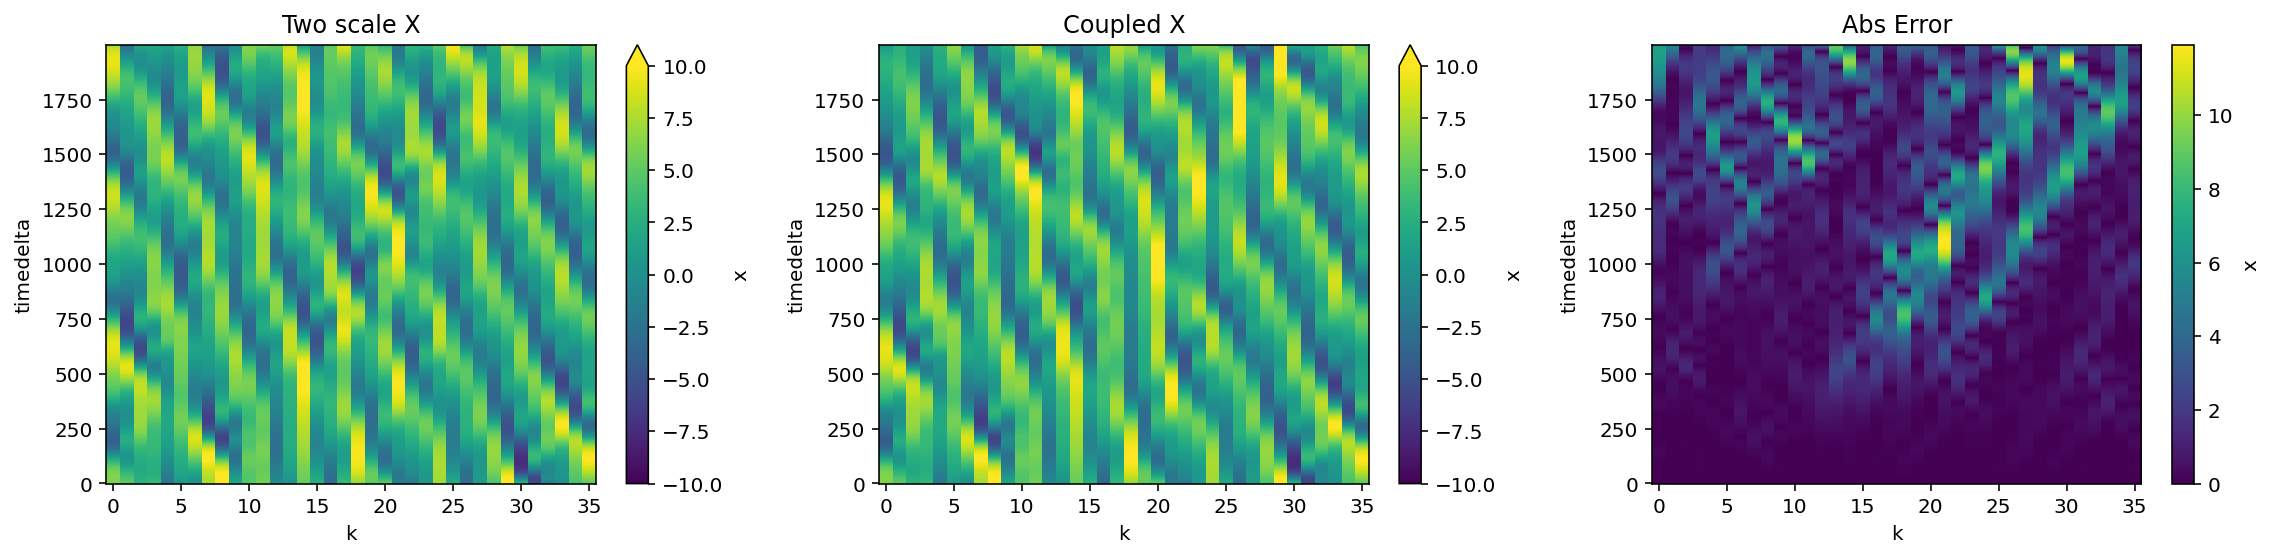

In [132]:
# Comparing predictions of `X` with and without interactions with `Y`
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
vmin, vmax = -10.0, 10.0

targets_slow_ds.x.plot(x='k', y='timedelta', ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('Two scale X')
coupled_slow_ds.x.plot.imshow(x='k', y='timedelta', ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('Coupled X')

abs((coupled_slow_ds.x - targets_slow_ds.x)).plot.imshow(x='k', y='timedelta', ax=ax3)
ax3.set_title('Abs Error')
plt.tight_layout()

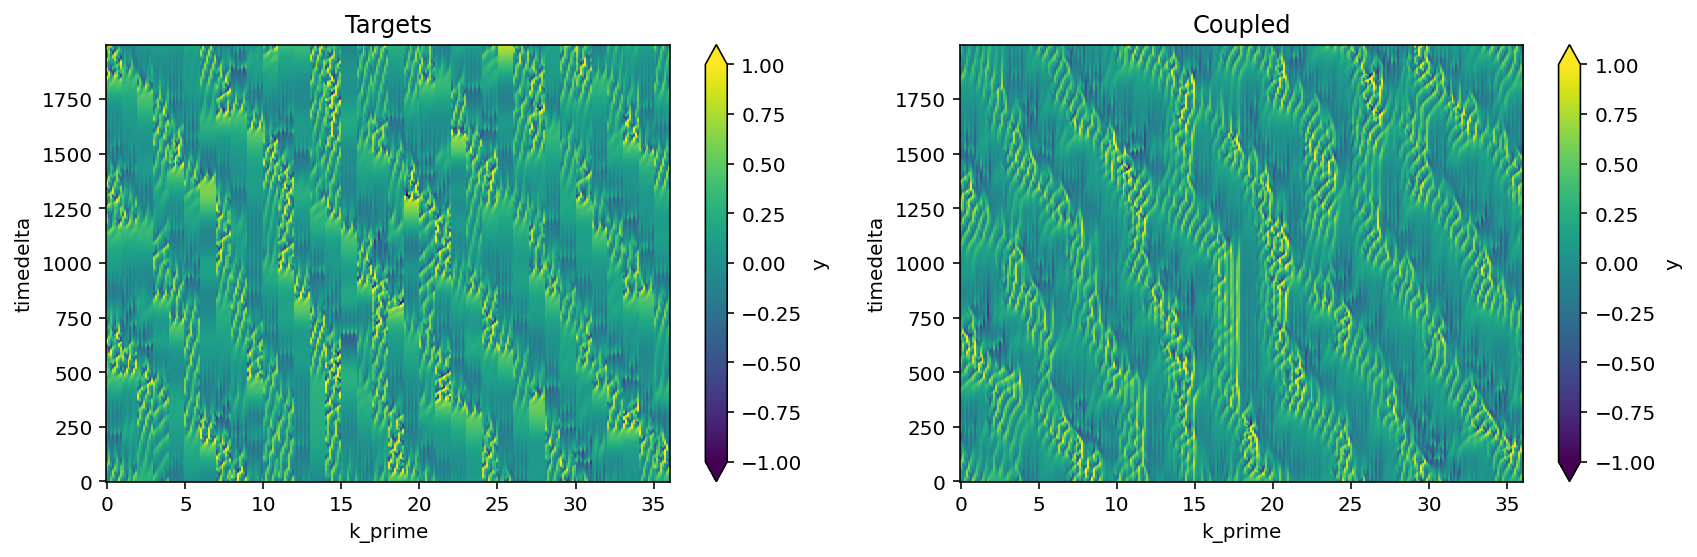

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
vmin, vmax = -1, 1
targets_fast_ds.y.plot.imshow(x='k_prime', y='timedelta', ax=ax1, vmin=vmin, vmax=vmax)
ax1.set_title('Targets')
coupled_fast_ds.y.plot.imshow(x='k_prime', y='timedelta', ax=ax2, vmin=vmin, vmax=vmax)
ax2.set_title('Coupled')
plt.tight_layout()

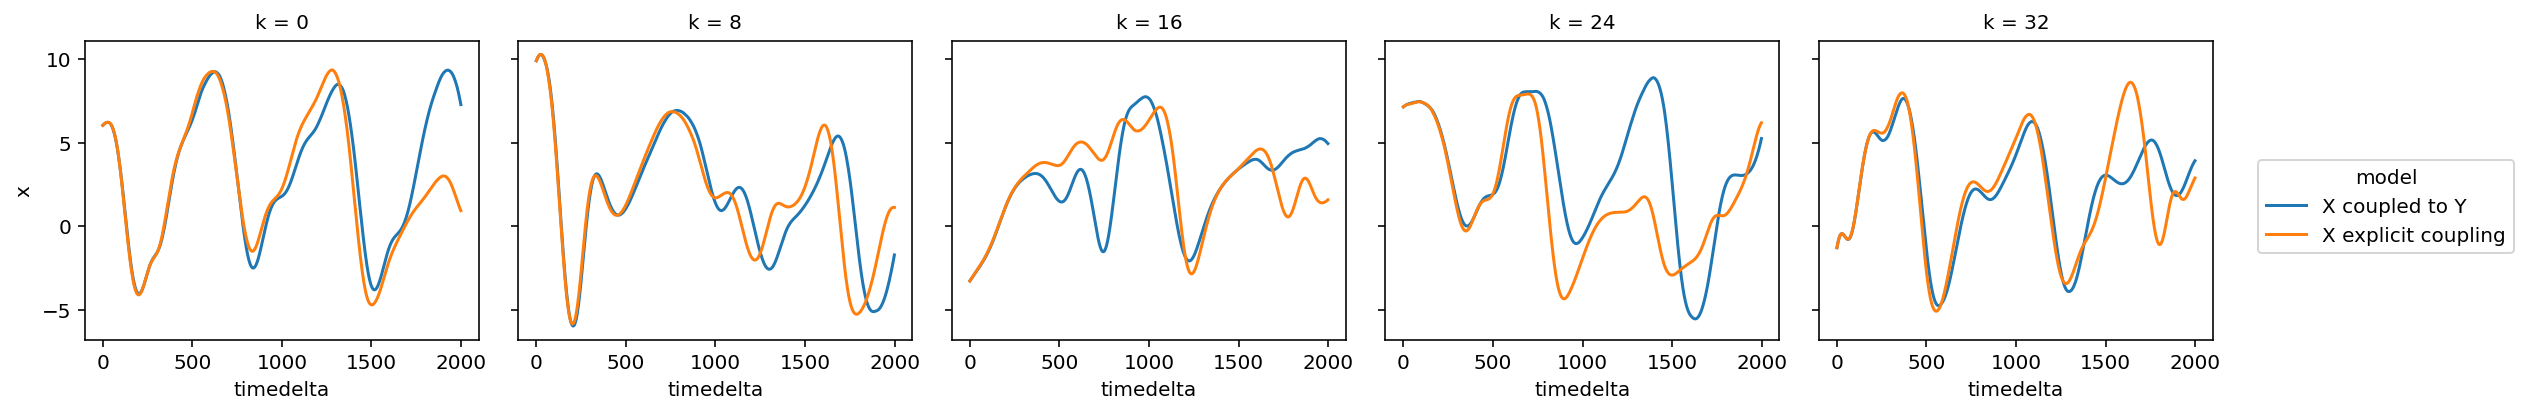

In [134]:
combined_ds = xarray.concat([targets_slow_ds, coupled_slow_ds], 'model')
combined_ds.coords['model'] = ['X coupled to Y', 'X explicit coupling']
combined_ds.thin(k=8).x.plot(x='timedelta', col='k', hue='model')

To wrap things up let's take a look at correlation between the forcing term in different simulations, by plotting $U_k$ vs $X_k$ distributions where: $U_{k} = \frac{hc}{b}\sum_{j}Y_{jk}$

In [135]:
coupled_fast_raw_ds = xarray_utils.fields_to_xarray(all_predictions['fast'])
coupled_uk = (h * c / b) * coupled_fast_raw_ds.y.sum('j')

target_fast_raw_ds = xarray_utils.fields_to_xarray(all_targets['fast'])
target_uk = (h * c / b) * target_fast_raw_ds.y.sum('j')

forced_fast_raw_ds = xarray_utils.fields_to_xarray(forced_y_predictions['fast'])
x_forced_uk = (h * c / b) * forced_fast_raw_ds.y.sum('j')

In [136]:
def plot_u_vs_x_pdf(u, x, ax):
  x_bins = np.linspace(-4, 4)
  y_bins = np.linspace(-7, 12)
  ax.hist2d(
      x.values.flatten(),
      u.values.flatten(),
      bins=(x_bins, y_bins),
      density=True,
  )
  ax.set_xlabel('$X_k$')
  ax.set_ylabel(r'$U_k = \frac{hc}{b}\sum_j Y_{j,k}$')

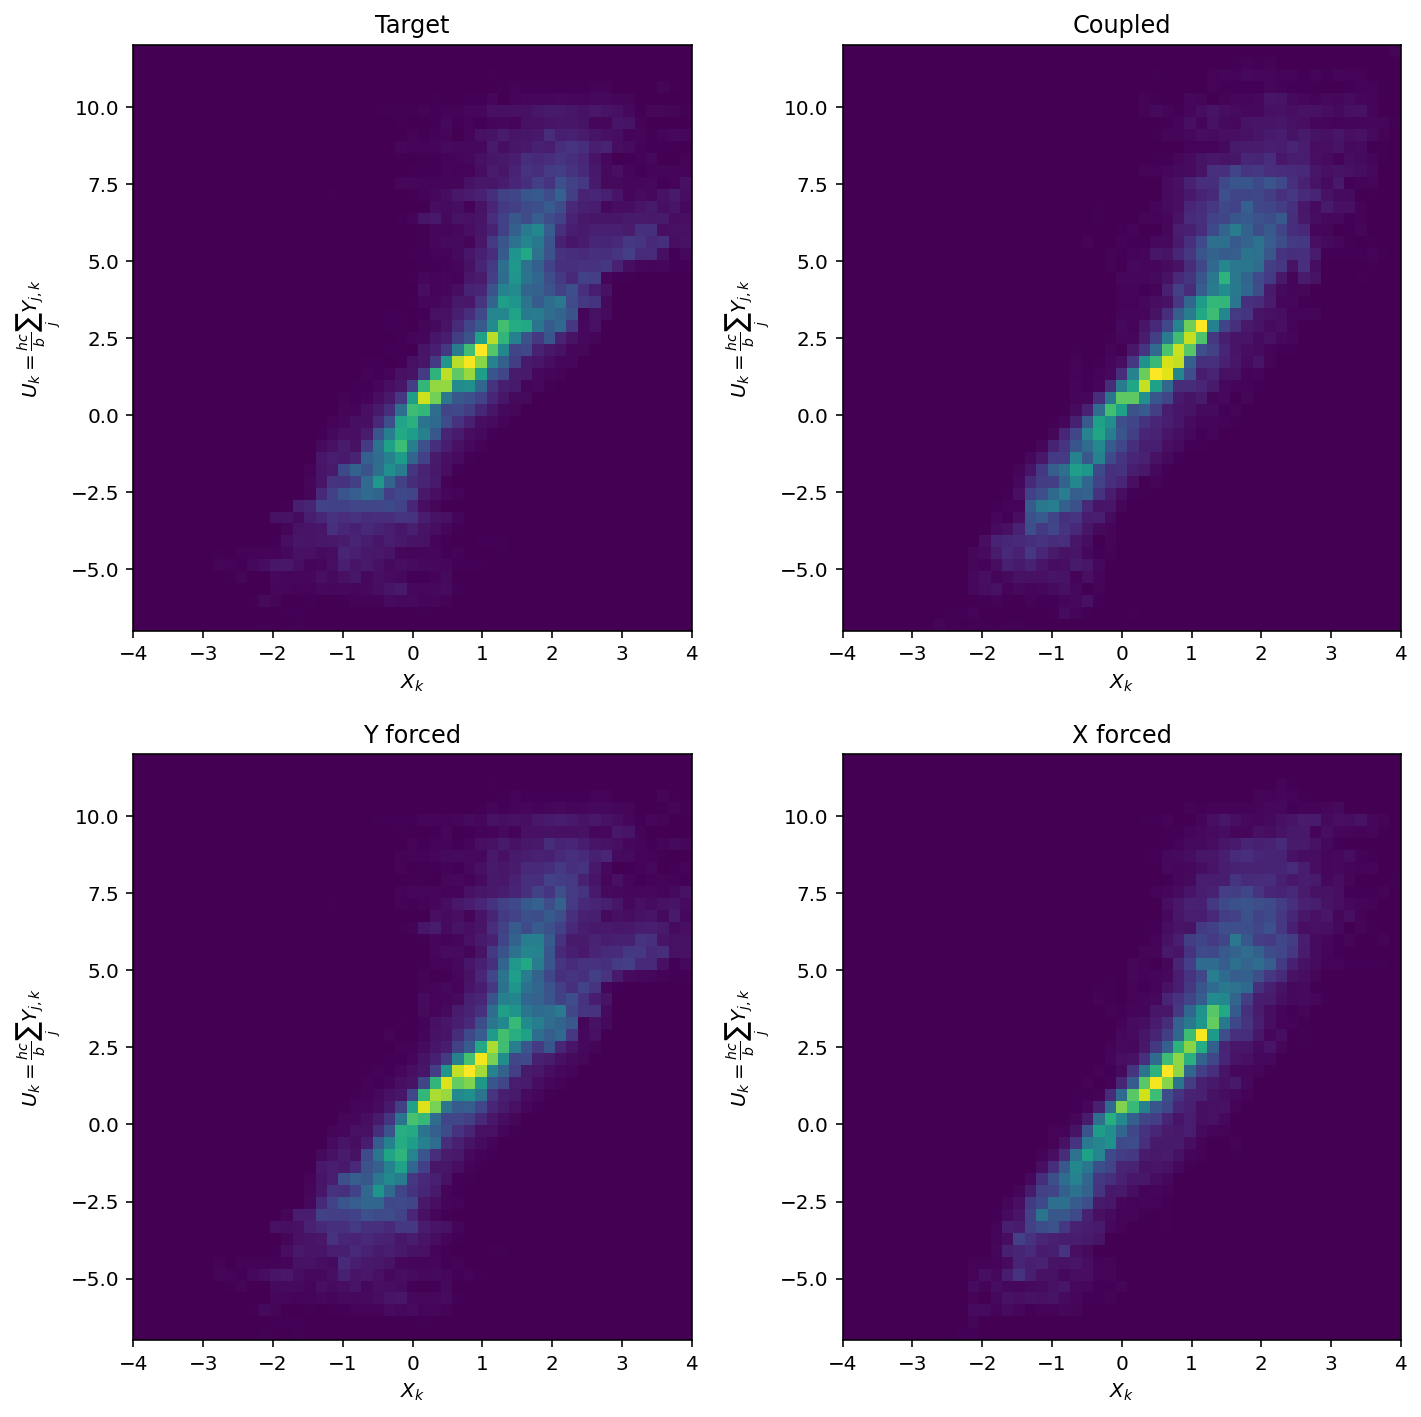

In [137]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
plot_u_vs_x_pdf(targets_slow_ds.x, target_uk, ax1)
ax1.set_title('Target')
plot_u_vs_x_pdf(coupled_slow_ds.x, coupled_uk, ax2)
ax2.set_title('Coupled')
plot_u_vs_x_pdf(forced_x_slow_ds.x, target_uk, ax3)
ax3.set_title('Y forced')
plot_u_vs_x_pdf(targets_slow_ds.x, x_forced_uk, ax4)
ax4.set_title('X forced')
plt.tight_layout()